In [ ]:
#!pip install prophet
#!pip install seaborn
#!pip install plotly
#!pip install nbformat
#!pip install statsmodels
#!pip install pmdarima
#!pip install xgboost
#!pip install catboost

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from pmdarima import auto_arima
from catboost import CatBoostRegressor
import xgboost as xgb
from prophet import Prophet

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 8

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="A date index has been provided")
warnings.filterwarnings("ignore", message="No supported index is available")
warnings.filterwarnings("ignore", message="divide by zero encountered")
warnings.filterwarnings("ignore", message="An unsupported index was provided and will be ignored when e.g. forecasting.")

import numpy as np
from catboost import CatBoostRegressor

# Introducción y Preprocesamiento: Análisis descriptivo.

In [ ]:
df = pd.read_csv('acciones_electrostock.csv', sep = ',')

In [ ]:
df.columns
#Tenemos 250 filas desde 2022-07-05 hasta 2023-07-03

df = df.rename(columns={'Adj Close': 'Adj_Close'})
# Nuestras columnas son, 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'
#He cambiado el nombre de Adj Close porque la separación.

# Información sobre las columnas.

'Date': Esta columna contiene la fecha en la que se registraron los datos correspondientes a las otras columnas.

'Open': Esta columna indica el precio de apertura de las acciones de la compañía eléctrica en el mercado al comienzo del día de negociación.

'High': Representa el precio más alto alcanzado por las acciones de la compañía durante el período de tiempo especificado (en este caso son datos diarios).

'Low': Indica el precio más bajo alcanzado por las acciones de la compañía durante el mismo período de tiempo.

'Close': Muestra el precio de cierre de las acciones de la compañía al final del período de tiempo (normalmente al final del día de negociación).

'Adj_Close' (Adjusted Close): Este valor representa el precio de cierre ajustado, que tiene en cuenta eventos como dividendos, divisiones de acciones u otros ajustes que puedan afectar el precio. Es por este motivo que es nuestra variable TARGET.

'Volume': Indica el número total de acciones de la compañía eléctrica que se negociaron durante el período de tiempo especificado. Representa el volumen de operaciones o la cantidad de acciones que cambian de manos.

In [ ]:
df.describe().T.round(4)
#redondeamos a 4 para hacerlo más legible.

,count,mean,std,min,25%,50%,75%,max
Open,251.0,5.733290e+01,5.4173,44.9300,5.206000e+01,5.896000e+01,6.201500e+01,64.980
High,251.0,5.779940e+01,5.3501,45.8200,5.250000e+01,5.932000e+01,6.251000e+01,65.050
Low,251.0,5.681610e+01,5.3842,44.6100,5.164500e+01,5.833000e+01,6.145000e+01,64.430
Close,251.0,5.729610e+01,5.3527,44.8600,5.206500e+01,5.886000e+01,6.181000e+01,64.950
Adj_Close,251.0,5.524640e+01,6.0736,42.4353,4.898680e+01,5.737470e+01,6.018370e+01,64.073
Volume,251.0,1.811636e+06,778467.1147,487600.0000,1.239650e+06,1.616400e+06,2.244300e+06,4875300.000


La columna "Adj_Close" muestra una mayor variabilidad en los valores respecto a las otras variables, con un promedio de alrededor de 55.25, un mínimo de 42.44 y un máximo de 64.07.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       251 non-null    object 
 1   Open       251 non-null    float64
 2   High       251 non-null    float64
 3   Low        251 non-null    float64
 4   Close      251 non-null    float64
 5   Adj_Close  251 non-null    float64
 6   Volume     251 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


La columna "Date" parece contener valores de tipo object, lo que generalmente indica que se trata de fechas representadas como cadenas de texto.


No hay valores nulos en ninguna de las columnas, ya que todas tienen 251 valores no nulos.

In [ ]:
df.isnull().sum()
#el Dataframe no contiene nulos

Date         0
Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64

In [ ]:
a = df.shape
print(f'Tenemos {a[0]} filas en {a[1]} columnas.')

Tenemos 251 filas en 7 columnas.


In [ ]:
d = df.duplicated().sum()
print(f"Hay {d} valores duplicados")

Hay 0 valores duplicados


In [ ]:
#Convertimos la columna Date en datetime.
df['Date'] = pd.to_datetime(df['Date'])

# VISUALIZACIÓN DE DATOS

In [ ]:
fig = make_subplots(rows=3, cols=2, subplot_titles=df.columns[1:])

# Iteramos sobre las columnas y agregamos un gráfico de líneas en cada subfigura
for i, column in enumerate(df.columns[1:]):
    row = i // 2 + 1
    col = i % 2 + 1
    fig.add_trace(go.Scatter(x=df['Date'], y=df[column], name=column), row=row, col=col)
    fig.update_xaxes(showgrid=True, gridcolor='lightgrey', row=row, col=col)
    fig.update_yaxes(showgrid=True, gridcolor='lightgrey', row=row, col=col)

fig.update_layout(height=800, width=1400, title_text= 'ElectroStock S.A periodo 06-Julio-2022 a 03-Julio-202')
fig.show()


En las cinco primeras gráficas observamos que el dibujo es muy similar en cada una de las variables. Esto puede indicarnos que estas variables están correlacionadas o están influenciadas por factores comunes. Todas las variables representan precios de acciones en bolsa y están sujetas a patrones generales del mercado.

Además, observamos un movimiento ascendente desde finales de septiembre de 2022, que es su punto mínimo, hasta su máximo en enero de 2023. Esto nos indica que el Open, High, Low, Close y Adj_Close experimentan un período de aumento en ese intervalo de tiempo. Este aumento puede estar relacionado con factores como una mayor demanda de acciones de la empresa de electricidad, mejores resultados financieros, noticias positivas sobre la empresa o eventos del mercado que impulsen el precio de las acciones en general.

Una de las primeras hipotesis ha sido relacionarlas con la
–<span style="color: yellow;">guerra de Ucrania y el aumento de los precios a nivel europeo.–</span>

CIDOB. (2023). "El mundo en 2023: Diez temas que marcarán la agenda internacional". Notes Internacionals CIDOB, 283. Recuperado de https://www.cidob.org/es/publicaciones/serie_de_publicacion/notes_internacionals_cidob/283/el_mundo_en_2023_diez_temas_que_marcaran_la_agenda_internacional


citado de noticias """
El miedo a un invierno de escasez de suministros y crisis energética en la industria y los hogares ha acelerado una profundización en el mercado único de la energía en la UE. Europa ha consensuado un aumento de la compra de gas natural licuado –<span style="color: yellow;">un incremento del 70% según Bruegel–</span>, la reducción de la demanda de gas natural, así como nuevos acuerdos de compra de gas con otros actores como Noruega, Azerbaiyán o Argelia. 2023 será un año que requerirá esfuerzos más robustos frente a la incertidumbre de un futuro sin importaciones de gas ruso . """

Vamos a comprobar si esa subida entre el mínimo y el máximo de la empresa esta relacionado con este evento.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Definir el rango de fechas donde se produce la subida.
start_date = '26-09-2022'
end_date = '13-01-2023'

filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

start_value = filtered_df['Adj_Close'].iloc[0]
end_value = filtered_df['Adj_Close'].iloc[-1]

#Y calculamos el porcentaje de crecimiento que ha tenido la variable Adj_Close en ese periodo de tiempo.
percentage_increase = ((end_value - start_value) / start_value) * 100

El resultado asignado a la variable percentage_increase representa el porcentaje de cambio o aumento entre el valor inicial y el valor final. Indica cuánto ha aumentado (o disminuido si es negativo) el valor en términos porcentuales.

In [ ]:
print(f"{round(percentage_increase, 2)} es el porcentaje de aumento")

48.3 es el porcentaje de aumento


Ha priorí vemos que el porcentaje no están elevado como se esperaba en un primer momento ya que en el extracto de la noticia se espera hasta un 70% de subida.

In [ ]:
#Graficamos estos datos.

fig = go.Figure()

fig.add_trace(go.Scatter(x=filtered_df['Date'], y=filtered_df['Adj_Close'], mode='lines', name='Precio de Cierre Ajustado', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=[filtered_df['Date'].iloc[0], filtered_df['Date'].iloc[-1]], y=[start_value, start_value * 1.7], mode='lines', name='Aumento 70%'))
fig.add_trace(go.Scatter(x=filtered_df['Date'], y=filtered_df['Close'], mode='lines', name='Precio de Cierre', line=dict(color='violet')))

fig.update_layout(title='Variación de precios entre {} y {}'.format(start_date, end_date), xaxis_title='Fecha', yaxis_title='Precio de Cierre')

fig.show()

Durante el período analizado, hemos observado que el aumento en los precios de las acciones ha diferido de las expectativas iniciales aunque se proyectaba un incremento del 70%.

A pesar de que la gráfica muestra una tendencia ascendente en la mayoría del período analizado y que coincide en gran parte del 26-sept al 30-nov, el crecimiento real no ha mantenido su ritmo de crecimiento desde el precio minimo del año al precio máximo.

Es muy probable que esta tendencia haya visto interrumpida por las medias tomadas por el gobierno:

   1. Real Decreto-ley 6/2022 que produce una nueva reducción de los precios de los cargos de electricidad.
   2. Real Decreto-ley 20/2022 que prorroga la reducción del Impuesto Especial sobre la Electricidad de un 5,1% a tan solo un 0,5%.
   3. El anterior Real-Decreto que  prorroga la reducción del IVA del 10% al 5%.
   4. Real Decreto-ley 10/2022 por le que se ha estableció el denominado mecanismo de ajuste del tope del precio al gas, que permite el desacoplamiento del precio del gas que se utiliza para generar la electricidad.

"Datos extraídos de: Nuevas medidas del gobierno en marzo 2022 para contener el precio de la luz. Disponible en: https://www.totalenergies.es/es/hogares/blog/energia-actualidad/nuevas-medidas-gobierno-marzo-2022-contener-precio-luz."

En resumen: en octubre y noviembre el crecimiento ha sido constante y de un 70% tal y como marca la linea roja.  Si bien podemos observar que al comenzar diciembre este crecimiento se ha ido frenando e impidió llegar a un crecimiento del 70%, también podemos afirmar que el contexto geopolítico de la guerra entre Rusia y Ucrania ha influido en el precio de las acciones de la compañia ya que durante todo el periodo ha tenido un crecimiento total del 48.3%

In [ ]:
#Graficamos todas las variables en un gráfico de líneas, menos la variable volume que tiene unas medidas distintas.
fig = go.Figure([go.Scatter(x=df['Date'], y=df[column], name=column) for column in df.columns[1:-1]])

fig.update_layout(title='Open, High, Low, Close y Adj_Close sobre fechas')

fig.update_xaxes(showgrid=True, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridcolor='lightgrey')

fig.show()

En esta gráfica observamos las 5 variables directamente relaccionadas con los precios de las acciones. Su movimiento y tendencias son muy parecidas.
Eso quiere decir que existe una estrecha relación y una tendencia similar entre las variables representadas en el gráfico. El hecho de que las líneas correspondientes a las diferentes variables estén cercanas entre sí y fluctúen de manera similar sugiere una correlación y una posible dependencia entre ellas.

Por lo tanto podemos inferir que los movimientos en una variable tienden a acompañar a los movimientos en las demás.

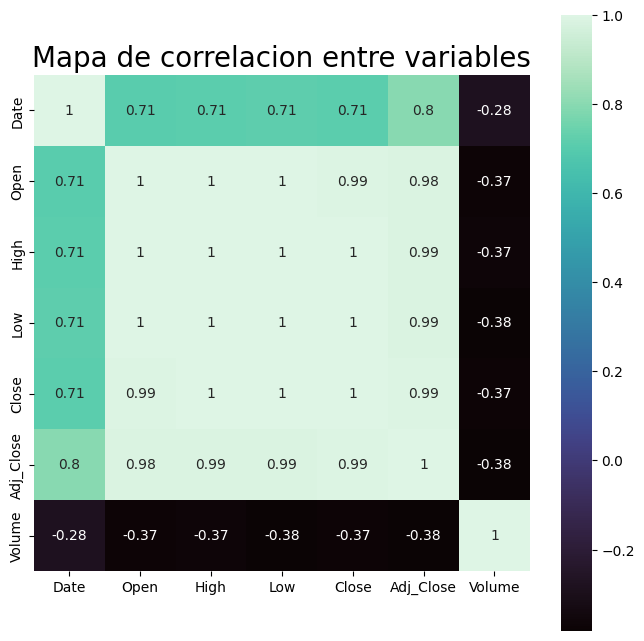

In [ ]:
#Realizamos un mapa de correlacion para comprobar si nuestra hipotesis de que las variables estan muy correlacionadas es cierta.

df_numeric = df.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(df_numeric, cmap= 'mako', annot=True, square=True)
plt.title("Mapa de correlacion entre variables", fontsize=20)
plt.show()

En este mapa de correlación, podemos observar que todas las variables presentan una correlación muy alta, que varía desde 0.71 hasta 1. Esto indica que existe una relación fuerte y positiva entre estas variables. Sin embargo, esta correlación alta no se aplica a la variable 'Volume', la cual muestra una correlación negativa que oscila entre -0.28 y -0.38.

La correlación negativa de 'Volume' indica que puede existir una relación inversa con las otras variables. Es decir, cuando el volumen de negociación aumenta, las otras variables tienden a disminuir y viceversa. Esta relación puede ser interesante de analizar y puede indicar ciertas dinámicas específicas relacionadas con el volumen de negociación en el contexto de la empresa de electricidad y sus acciones en bolsa. Es importante tener en cuenta que el volumen por sí solo no proporciona información completa sobre la dirección futura de los precios.

### VOLATILIDAD

In [ ]:
#Hacemos una copia de nuestro datos.
df1 = df.copy()

df1['Daily_Return'] = df1['Close'].pct_change()

volatilidad = df1['Daily_Return'].std()

print("Volatilidad: ", volatilidad)

Volatilidad:  0.018728502675225567


La volatilidad es una medida de la fluctuación de los precios de un activo.
En este caso, una volatilidad de 0.018728... significa que los rendimientos diarios de las acciones de la empresa de electricidad presentaron una variabilidad moderada durante el periodo considerado, fluctuaciones de magnitud moderada e indican un mercado más estable y menos sujeto a cambios drásticos en el precio.

In [ ]:
fig = px.line(df, x='Date', y=df.columns[2:4], title='Valores mínimos y máximos en el tiempo.')

fig.add_trace(go.Scatter(x=df['Date'], y=df[df.columns[2]], fill='tonexty', name='Area', showlegend=False, fillcolor='pink',
                         line=dict(color='rgba(0,0,0,0)')))  # Línea transparente central

fig.show()

El espacio pintado entre las líneas de 'High' y 'Low' en este gráfico lineal representa el rango de precios dentro del cual oscilan los valores diarios.

Un espacio más amplio entre las líneas de 'High' y 'Low' indica una mayor volatilidad y fluctuaciones más significativas en los precios, mientras que un espacio más estrecho indica una menor volatilidad y movimientos más estables.

Si el espacio entre las líneas es estrecho y se mantiene constante durante un período de tiempo, esto puede indicar una consolidación del precio. Por otro lado, si el espacio es amplio y presenta movimientos bruscos, esto puede indicar momentos de alta volatilidad y cambios significativos en el mercado.


<img src="comparativa.png" alt="Logo" width="700" height="200">   

In [ ]:
#Cargamos los datos que hemos encontrado en la página abajo indicada.

naturgy = pd.read_csv('historico de Naturgy.csv', sep =';')
endesa = pd.read_csv('endesa.csv', sep=';', encoding='latin1')

Datos extraidos de : Naturgy Energy Group S.A. (NTGY) y Endesa S.A. (ELE) investing.com https://goo.su/EFNW3mV

In [ ]:
#Preparamos los datos para poder trabajar con ellos y graficarlos.
naturgy.drop('% var.', axis=1, inplace= True)
endesa.drop('% var.', axis=1, inplace= True)

In [ ]:
#Nombramos las columnas igual que nuestro dataframe original.
map = {'Fecha': 'Date', 'Último': 'Close', 'Apertura': 'Open', 'Máximo': 'High', 'Mínimo': 'Low', 'Vol.': 'Volume'}

for old_col, new_col in map.items():
    naturgy = naturgy.rename(columns={old_col: new_col})
    endesa = endesa.rename(columns={old_col: new_col})

In [ ]:
#Damos formato datetime a la columna ['Date] para uqe tengoa el mismo que nuestro df de ElectroStock
naturgy['Date'] = pd.to_datetime(naturgy['Date'], format = "%d.%m.%Y")
endesa['Date'] = pd.to_datetime(endesa['Date'], format = "%d.%m.%Y")
naturgy['Date'] = pd.to_datetime(naturgy['Date'], format="%d.%m.%Y").dt.strftime("%d-%m-%Y")
endesa['Date'] = pd.to_datetime(endesa['Date'], format="%d.%m.%Y").dt.strftime("%d-%m-%Y")

In [ ]:
#Remplazamos las comas por puntos para poder convertirlo a float.
cols_to_replace = ['Open', 'High', 'Close', 'Low', 'Volume']

for col in cols_to_replace:
    naturgy[col] = naturgy[col].str.replace(',', '.')
    endesa[col] = endesa[col].str.replace(',', '.')

In [ ]:
#Aquí definimos una función que multiplique por 1000 donde hay una 'K' y por 1000000 donde haya una 'M'.
def convertir(value):
    if value.endswith('K'):
        return float(value[:-1]) * 1000
    elif value.endswith('M'):
        return float(value[:-1]) * 1000000
    else:
        return float(value)
#Iteramos por ambos dataframes para aplicar la función convertir
naturgy['Volume'] = naturgy['Volume'].apply(convertir)
endesa['Volume'] = endesa['Volume'].apply(convertir)

In [ ]:
# Convertimos las columnas a tipo float menos Date.

cols_to_convert = ['Open', 'Close', 'High', 'Low', 'Volume']
naturgy[cols_to_convert] = naturgy[cols_to_convert].astype(float)
endesa[cols_to_convert] = endesa[cols_to_convert].astype(float)

In [ ]:
#Ordenamos los valores de Date.
naturgy['Date'] = pd.to_datetime(naturgy['Date'], format="%d-%m-%Y")
naturgy = naturgy.sort_values('Date')
endesa['Date'] = pd.to_datetime(endesa['Date'], format="%d-%m-%Y")
endesa = endesa.sort_values('Date')

#Borro estos valores por ser valores extraños. Aparecen totalmente fuera de rango.
endesa.loc[endesa['Date'] == '17-03-2023', 'Volume'] = 2007000
endesa.loc[endesa['Date'] == '15-06-2023', 'Volume'] = 2007000

In [ ]:
fig = go.Figure()

# Agregarmos tres lineas, Naturgy, ElectroStock y Endesa analizar la variable Close.
fig.add_trace(go.Scatter(x=naturgy['Date'], y=naturgy['Close'], name='Naturgy Energy Group, S.A.'))
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name = 'ElectroStock, S.A.'))
fig.add_trace(go.Scatter(x=endesa['Date'], y=endesa['Close'], name = 'Endesa, S.A.'))

fig.update_layout(title='Comparativa de cierre.',
                  xaxis=dict(showgrid=True, gridcolor='lightgrey'),
                  yaxis=dict(showgrid=True, gridcolor='lightgrey'))
fig.show()

Las lineas de la gráfica comparativa sugieren que ElectroStock S.A. ha tenido un rendimiento sobresaliente en comparación con sus competidores. La línea que representa el cierre de ElectroStock se encuentra notablemente más alta que las líneas de Naturgy y Endesa. Esto indica que ElectroStock ha obtenido resultados superiores en términos de rendimiento financiero.

Además, se observa que la subida esperada del 70% es mucho más suavizada en el periodo estudiado en comparación con ElectroStock. Esto significa que la tendencia alcista en los datos de ElectroStock es más pronunciada y diferenciada en comparación con sus competidoras.

Podemos concluir que ElectroStock muestra una mayor variabilidad en sus resultados y un desempeño superior en comparación con Naturgy y Endesa. Estos resultados resaltarían la fortaleza y competitividad de ElectroStock en el mercado y que el periodo antes analizado ha sido mucho más favorable para ElectroStock que para el resto.

In [ ]:
fig = go.Figure()

# Agregarmos tres lineas, Naturgy, ElectroStock y Endesa analizar la variable Volume
fig.add_trace(go.Scatter(x=naturgy['Date'], y=naturgy['Volume'], name='Naturgy Energy Group S.A.'))
fig.add_trace(go.Scatter(x=df['Date'], y=df['Volume'], name = 'ElectroStock S.A.'))
fig.add_trace(go.Scatter(x=endesa['Date'], y=endesa['Volume'], name = 'Endesa, S.A.'))

fig.update_layout(title='Comparativa VOLUME entre compañias.',
                  xaxis=dict(showgrid=True, gridcolor='lightgrey'),
                  yaxis=dict(showgrid=True, gridcolor='lightgrey'))

fig.show()

En la gráfica de volumen se observa que ElectroStock tiene numerosos picos que son amplios en duración y magnitud. La mayoría del periodo se mantiene por encima de las otras dos compañías. Esto sugiere que ElectroStock ha experimentado altos volúmenes de transacciones en comparación con Naturgy y Endesa, lo que indica un mayor interés y actividad en el mercado hacia ElectroStock.

Endesa, por su parte, se ubica entre ElectroStock y Naturgy en términos de volumen. Si bien su nivel de volumen es más alto que Naturgy, está por debajo de ElectroStock. Sin embargo, se observan puntualmente algunos picos muy marcados que indican momentos de mayor actividad y transacciones en esos días específicos.

En contraste, Naturgy se encuentra por debajo de las otras dos empresas en términos de volumen. Sus picos son mucho menos pronunciados y, en pocas ocasiones, supera a Endesa y un par de veces a ElectroStock. Esto sugiere que Naturgy ha tenido un nivel de actividad y volumen de transacciones más bajo en comparación con sus competidores.

La gráfica  muestra que ElectroStock ha tenido consistentemente altos volúmenes de transacciones por encima de sus competidores.

# VARIABLE VOLUME

In [ ]:
#Graficamos por días la variable volume para observar su comportamiento.
#250 bins porque son 250 días.
fig = px.histogram(df, x='Date', y= 'Volume', nbins= 250, title='Volume sobre el Data')
fig.show()

En la gráfica de barras que representa el volumen de negociación diario, se observa que algunos días están vacíos de datos, lo cual coincide con los domingos. Los domingos no hay actividad en el mercado de valores, ya que muchas bolsas de valores suelen cerrar.

Además, se puede apreciar que los días con mayor volumen de negociación, por lo general, son los jueves y martes, mientras que los miércoles suelen tener los valores más bajos. Este patrón puede indicar ciertas tendencias o preferencias en el comportamiento de los participantes del mercado.

Una posible interpretación de estos hallazgos es que los inversores tienden a ser más activos los martes y jueves debido a que toman decisiones basadas en eventos económicos o noticias relevantes que se suelen publicar en esos días.
Por lo tanto podemos intuir que hay una estacionalidad semanal pero sin un análisis estadístico más profundo y exhaustivo, no se puede afirmar con certeza que haya una estacionalidad semanal en el mercado de valores basándonos únicamente en el patrón observado en la gráfica de barras mencionada.
No obstante en este trabajo yo lo voy a tomar asi, pues carezco de conocimientos para realizar otros análisis economicos.

In [ ]:
fig = px.line(df, x='Date', y=['Adj_Close', 'Volume'], title='Adj_Close y Volume sobre fecha',
              color_discrete_map={'Adj_Close': 'orange', 'Volume': 'blue'})

fig.update_layout(xaxis_title='Fecha', yaxis_title='Valor Escalado')

fig.show()

Comparamos las variables 'Adj_Close' y el volumen en un mismo gráfico, pero debido a las diferencias en los valores de cada una, la visualización puede resultar poco clara. Para solucionar esto escalaremos los valores

In [ ]:
scaler = MinMaxScaler()
df[['Volume', 'Adj_Close']] = scaler.fit_transform(df[['Volume', 'Adj_Close']])

In [ ]:
fig = px.line(df, x='Date', y=['Volume', 'Adj_Close'], title='Volume and Adj_Close Over Time',
              labels={'value': 'Scaled Value'}, color_discrete_sequence=['blue', 'orange'])

fig.update_layout(xaxis_title='Fecha', yaxis_title='Valor de la escala')

fig.show()


Se observan ciertos movimientos que sugieren una correlación inversa entre los valores de cierre ajustado y el volumen de transacciones. En los puntos en los que el precio de cierre ajustado es más alto, el volumen de transacciones tiende a ser significativamente menor. Del mismo modo, durante un período específico (del 23 de agosto al 27 de octubre de 2022), se observa que los precios de cierre de las acciones son los más bajos de todo el período, pero el volumen de transacciones es notablemente más alto.

Este patrón podría indicar que cuando los precios de cierre de las acciones son altos, los inversores pueden mostrar menos interés en operar, lo que resulta en un menor volumen de transacciones. Por otro lado, durante el período en el que los precios de cierre son bajos, el mercado puede volverse más activo y atractivo para los inversores, lo que genera un aumento en el volumen de transaccione

In [ ]:
#invertimos el escalado.

df[['Volume', 'Adj_Close']] = scaler.inverse_transform(df[['Volume', 'Adj_Close']])

Gráfico de cajas (box plot)

In [ ]:
fig1 = go.Figure()

# Agregamos los box plots para Open, High, Low y Close
for column in ['Open', 'High', 'Low', 'Close']:
    fig1.add_trace(go.Box(y=df[column], name=column))

# Calculamos la media de los valores de Open, High, Low y Close
mean_values = np.mean(df[['Open', 'High', 'Low', 'Close']], axis=0)

# Agregamos la línea que representa la media
fig1.add_shape(type='line',
               x0=0,
               y0=mean_values[0],
               x1=1,
               y1=mean_values[0],
               line=dict(color='red', width=2),
               xref='paper',
               yref='y')

# Configuramos el diseño del box plot para Open, High, Low y Close
fig1.update_layout(title='Box Plot - Open, High, Low, Close')
fig1.update_xaxes(showgrid=True, gridcolor='lightgrey')
fig1.update_yaxes(showgrid=True, gridcolor='lightgrey')

fig1


Hemos agregado una línea horizontal en el gráfico que representa la media de los valores de 'Open', 'High', 'Low' y 'Close'. La línea se coloca en la posición del promedio y se muestra en color rojo. Como vemos los valores de las columnas 'Open', 'High', 'Low' y 'Close' , en promedio, tienden a ser mayores que la media. Esto podría indicar que, en general, los precios de apertura, máximos, mínimos y cierre son relativamente altos en comparación con el promedio de los datos.

In [ ]:
# Creamos el box plot para Volume
fig2 = go.Figure()

fig2.add_trace(go.Box(y=df['Volume'], name='Volume'))
fig2.update_layout(title='Box Plot - Volume',
                   width=500,
                   height=500
                  )
fig2.update_xaxes(showgrid=True, gridcolor='lightgrey')
fig2.update_yaxes(showgrid=True, gridcolor='lightgrey')

fig2.show()


Este gráfico muestra la distribución de los datos en el volumen de transacciones. Los puntos que se encuentran por encima de los bigotes son considerados valores atípicos o outliers. Estos valores atípicos indican que hay algunos datos extremadamente altos en la distribución del volumen de transacciones.

<img src="modelado series temporales.png" alt="Logo" width="700" height="200">


In [ ]:
#Realizamos una copia del df para empezar el analisis.
df_adj_Close = df[['Date', 'Adj_Close']].copy()
#Hemos considerado desplazar 7 lineas los datos por que sospechamos que va a ser semanal.
df_adj_Close['previous_value'] = df_adj_Close['Adj_Close'].shift(7)
display(df_adj_Close.head())


,Date,Adj_Close,previous_value
0,2022-07-05,47.722637,NaN
1,2022-07-06,45.772682,NaN
2,2022-07-07,46.910934,NaN
3,2022-07-08,46.770981,NaN
4,2022-07-11,46.136547,NaN


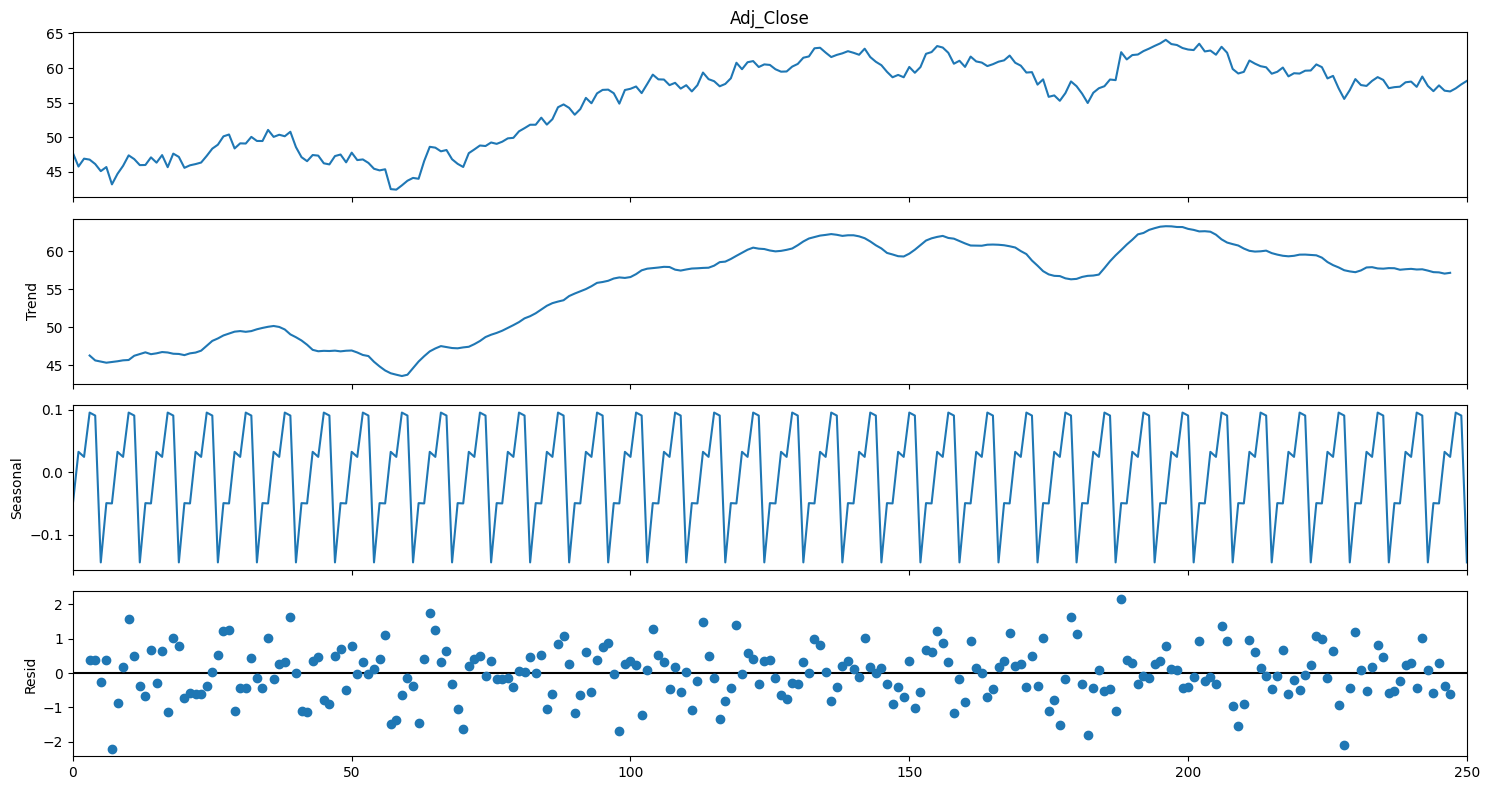

In [ ]:
result1 = seasonal_decompose(df_adj_Close['Adj_Close'] , model='additive', period=7)
result1.plot()
plt.show()

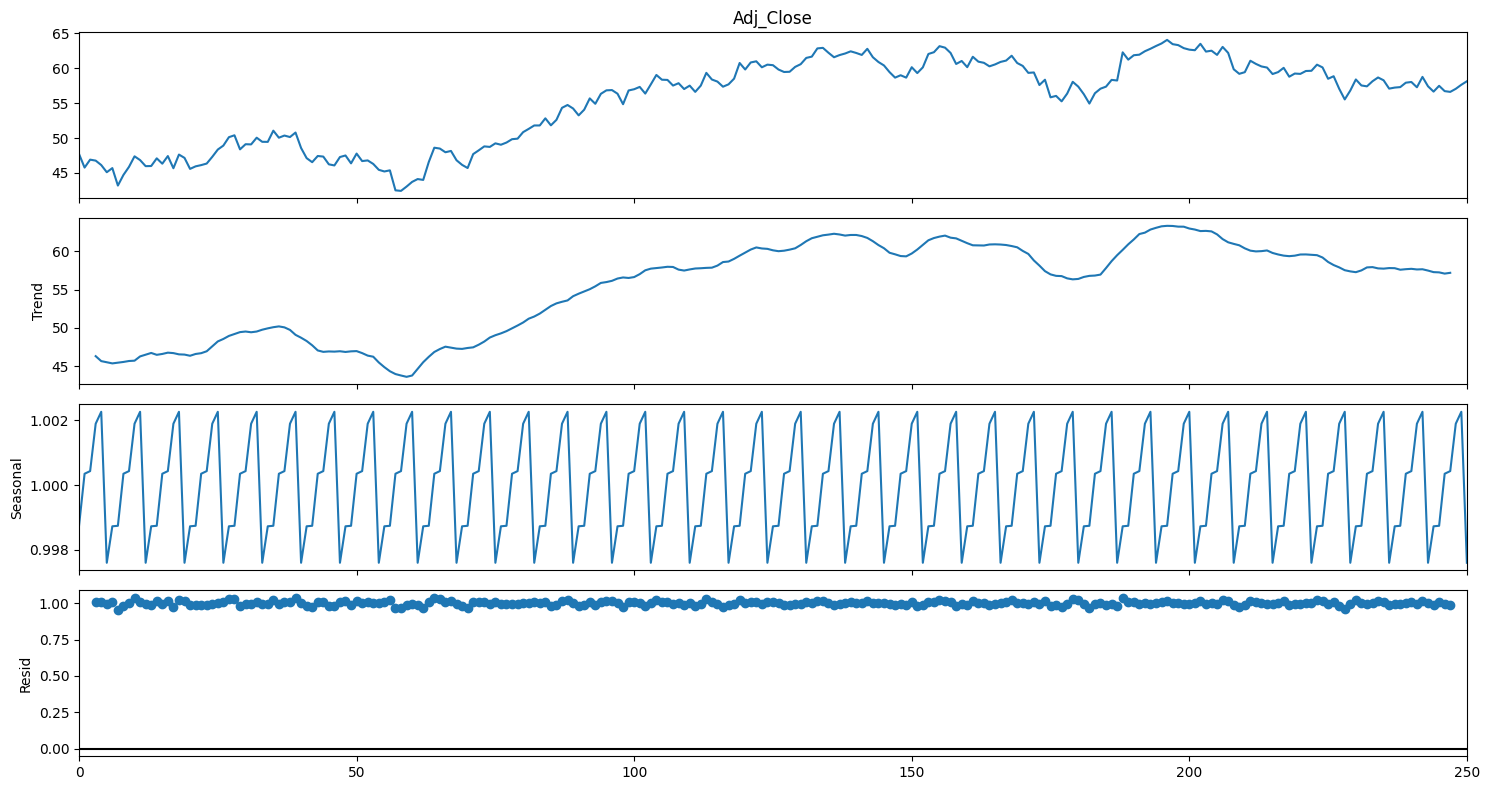

In [ ]:
result2 = seasonal_decompose(df_adj_Close['Adj_Close'], model='multiplicative', period=7)
result2.plot()
plt.show()

Hemos considerado adoptar la descomposición aditiva por la distribución de los residuos ya que los valores estan entre -1 y 1 y no todos sobre 1 como en la multiplicativa. En una descomposición aditiva, se asume que los componentes se suman entre sí para formar la serie de tiempo original. Si los residuos tienen una distribución simétrica alrededor de 0 y no muestran un aumento en la variabilidad a medida que la serie de tiempo crece, la descomposición aditiva es una buena opción.

In [ ]:
#Añadimos los datos al dataframe

df_adj_Close['observed'] = result1.observed
df_adj_Close['trend'] = result1.trend
df_adj_Close['seasonal'] = result1.seasonal
df_adj_Close['resid'] = result1.resid

In [ ]:
df_adj_Close.head()

,Date,Adj_Close,previous_value,observed,trend,seasonal,resid
0,2022-07-05,47.722637,NaN,47.722637,NaN,-0.049858,NaN
1,2022-07-06,45.772682,NaN,45.772682,NaN,0.032662,NaN
2,2022-07-07,46.910934,NaN,46.910934,NaN,0.024611,NaN
3,2022-07-08,46.770981,NaN,46.770981,46.303153,0.095462,0.372367
4,2022-07-11,46.136547,NaN,46.136547,45.656721,0.090702,0.389123


Se puede notar que la columna 'trend' captura la tendencia general de los valores ajustados de cierre a lo largo del tiempo.
La columna 'seasonal' muestra EL componente estacional, que indica los patrones estacionales recurrentes en los datos.
La columna 'resid' representa los residuos, que contienen la variación no explicada por la tendencia y la componente estacional.

In [ ]:
#verificamos que los tipos de las columnas sean todos los que le corresponde.

df_adj_Close.dtypes

Date              datetime64[ns]
Adj_Close                float64
previous_value           float64
observed                 float64
trend                    float64
seasonal                 float64
resid                    float64
dtype: object

In [ ]:
fig = px.line(df_adj_Close,
              x='Date',
              y=['Adj_Close', 'previous_value', 'observed', 'trend', 'seasonal', 'resid'])
fig.show()


La línea "observed" muestra una tendencia similar a la línea "trend" en la mayoría de los casos. Esto sugiere que los valores observados de "Adj_Close" se mantienen cerca de la estimación de tendencia a lo largo del período de tiempo analizado. Estos puntos representan momentos en los que los valores observados de "Adj_Close" han sido más bajos de lo que se esperaría según la tendencia estimada. Pueden ser considerados como caídas o anomalías en comparación con el comportamiento general de la serie temporal.

In [ ]:
#Para poder observarse mejor estacionalidad y el residuo los graficamos por separado.
fig = px.line(df_adj_Close,
              x='Date',
              y=['seasonal', 'resid'],
              color_discrete_sequence=['orange', 'aqua'])
fig.show()

Vemos claramente la presencia de una componente estacional en los datos. El hecho de que este patrón se repita de manera consistente a lo largo del tiempo sugiere que hay una influencia estacional predecible.

# AUTOCORRELACION Y AUTOCORRELACION PARCIAL

La autocorrelación es una medida estadística que muestra la similitud o relación entre una observación en un tiempo específico y las observaciones pasadas en diferentes momentos anteriores.

La autocorrelación parcial es similar a la autocorrelación, pero mide la correlación entre una observación en un tiempo específico y las observaciones pasadas, teniendo en cuenta las correlaciones indirectas a través de otros lags.

In [ ]:
df_corr = df['Adj_Close'].autocorr()

In [ ]:
df_corr

0.9867536270964753

el valor de 0.9867536270964753 indica una correlación muy cercana a 1, lo que sugiere que los valores sucesivos de la columna 'Adj_Close' están altamente correlacionados positivamente. Esto implica que existe una fuerte dependencia lineal entre los valores previos y actuales de la serie temporal.

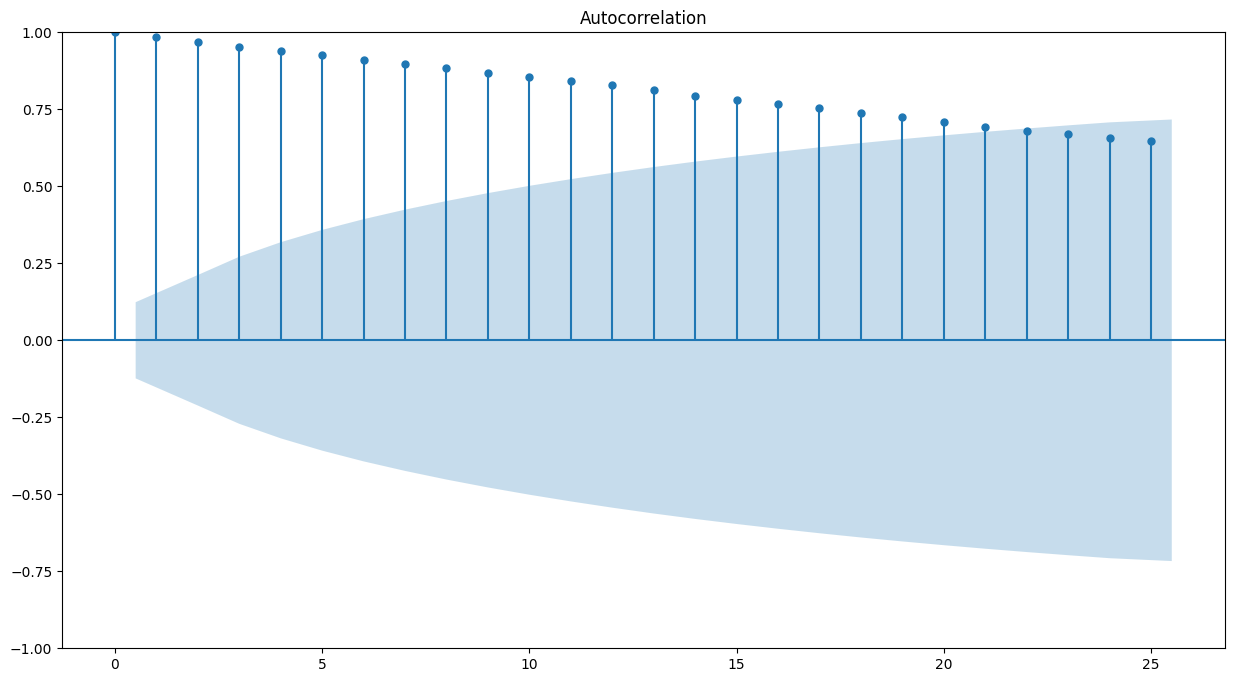

In [ ]:
plot_acf(df['Adj_Close'], lags = 25)
plt.show()

 Esto indica que hay una correlación significativa y positiva entre la serie en el presente y los valores rezagados hasta el rezago 22 . La disminución gradual en el valor de las correlaciones a medida que aumenta el rezago sugiere que la dependencia entre los valores de la serie disminuye a medida que se observan valores más lejanos en el tiempo.

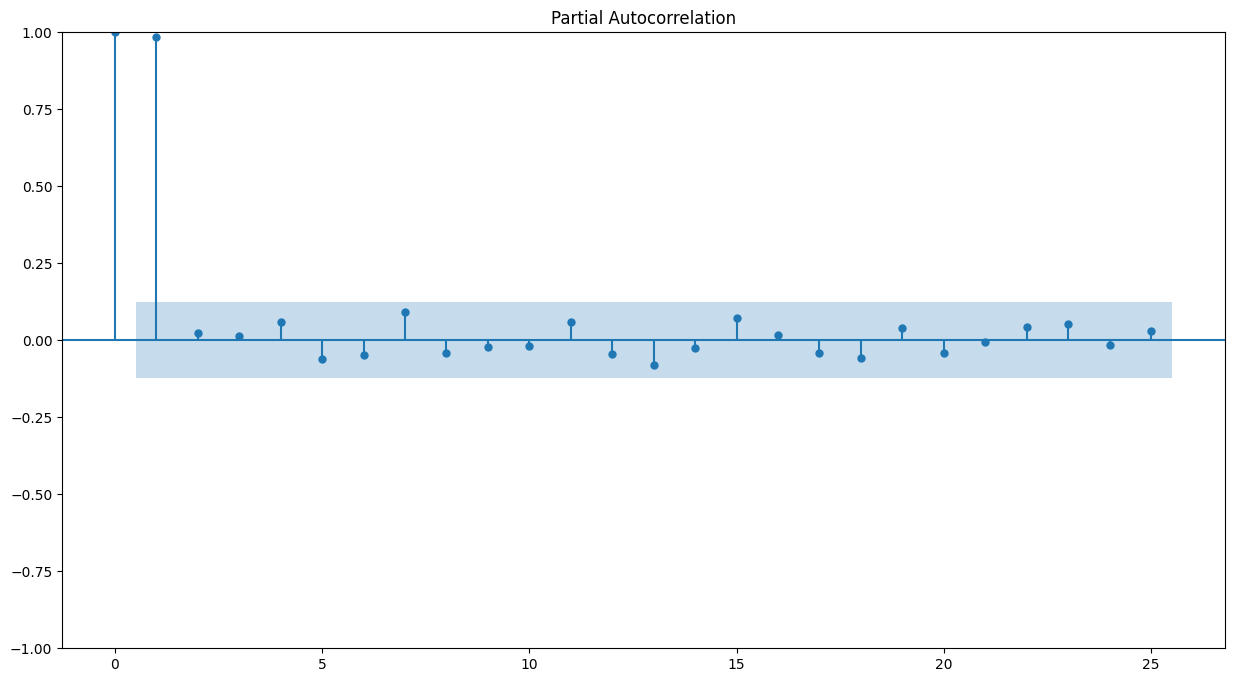

In [ ]:
plot_pacf(df['Adj_Close'], lags = 25)
plt.show()

Se observan que hay dos rezagos significativamente altos y el resto cae dentro de la zona de confianza, esto sugiere que existen correlaciones directas con dos lags pasados y no hay correlaciones significativas para lags mayores.

CONCLUSIONES:

Autocorrelación alta: La serie temporal de los valores "Adj_Close" muestra una alta autocorrelación positiva, lo que indica una fuerte dependencia lineal. Esta autocorrelación sugiere la presencia de una tendencia o patrón persistente en los datos a lo largo del tiempo, tal como se ha visto en las gráficas anteriores.

Componente estacional: La presencia de una componente estacional en la serie temporal se refleja en la línea "seasonal" en el gráfico. Aunque no haya fluctuaciones significativas, se observa un patrón estacional que se repite continuamente durante todo el año.

Correlaciones en rezagos: Al analizar la función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF), se observa que los primeros rezagos tienen correlaciones significativas y altas. Esto indica que los valores rezagados tienen una influencia significativa en la serie en el presente.

Componente residual: La línea "resid" en el gráfico representa los residuos después de ajustar la tendencia y la componente estacional. Los residuos reflejan la variabilidad no explicada por los componentes anteriores.

Basándonos en las conclusiones obtenidas a partir de la descomposición estacional de la serie de tiempo necesitamos realizar algunos ajustes antes de introducir los datos en un modelo ARIMA.

# IMPLANTACIÓN DE MODELOS.

AUTOARIMA

Comenzamos modelando el Autoarima que nos dará una visión general de los valores que tenemos que introducir en p, d y q.

Estos son los órdenes de los componentes del modelo que determinan cómo se modelan las relaciones y patrones en la serie de tiempo.
Más adelante evaluaremos su efectividad provando diferentes valores para el mismo modelo.

In [ ]:
model = auto_arima(df['Adj_Close'], seasonal=False)

predictions = model.predict(n_periods=365)

In [ ]:
model = auto_arima(df['Adj_Close'], seasonal=False)

In [ ]:
model.fit(df['Adj_Close'])

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

ARIMA (0, 1, 0) quiere decir que 'p', 'd' y 'q' son 0,1 0 respectivamente.

"p" (Orden del término autoregresivo): Representa el número de términos autoregresivos. En este caso, ARIMA ha determinado que el valor ideal es 0. Un valor "p" mayor indica que el modelo tendría en cuenta más observaciones pasadas para hacer predicciones futuras.

"d" (Orden de diferenciación): Representa el número de veces que la serie de tiempo se diferencia para hacerla estacionaria. AutoARIMA ha seleccionado que el valor ideal es 1.

"q" (Orden del término de media móvil): Representa el número de términos de media móvil en el modelo. En este caso, el modelo ha seleccionado 0, lo que significa que no se incluyen términos de media móvil en el modelo.

Ahora, para realizar la búsqueda tradicional del valor de "d", seguimos los siguientes pasos:

El valor de "d".

Comenzamos aplicando la diferenciación de primer orden (d=1) y verificamos si la serie temporal se vuelve estacionaria. Si la serie todavía no es estacionaria, repetiremos el proceso de diferenciación hasta que la serie se vuelva estacionaria. El valor de "d" será el número de veces que se aplicó la diferenciación para lograr la estacionariedad.

Antes de nada realizamos la prueba Dickey-Fuller para cercionarnos de que realmente no es estacionaria.

In [ ]:
# valor de d, aplicamos la prueba de Dickey-Fuller para evaluar la estacionariedad.

result = adfuller(df['Adj_Close'])
p_value = result[1]
p_value

0.5126390331679781

El valor es 0.51263.. por lo tanto no es estacionaria tal y como sospechabamos. En otras palabras, no podemos rechazar la hipótesis nula de que la serie contiene una raíz unitaria.

¿Porqué realizamos esto? Una serie de tiempo con una raíz unitaria se considera no estacionaria, lo que significa que su media y varianza cambian con el tiempo y exhibe patrones y tendencias a lo largo del tiempo. Para aplicar el modelo ARIMA de manera efectiva, es esencial que la serie de tiempo sea estacionaria, ya que el modelo asume que los datos son estables y no cambian sistemáticamente con el tiempo.

In [ ]:
# Aplicamos diferenciación de primer orden a la columna 'Adj_Close'. d = 1
df['Adj_Close_diff'] = df['Adj_Close'].diff()
# Eliminarmos las filas con valores nulos resultantes de la diferenciación
df.dropna(inplace=True)

In [ ]:
result = adfuller(df['Adj_Close_diff'])
p_value = result[1]
p_value

4.536747565164192e-30

In [ ]:
if p_value < 0.05:
    print("La serie diferenciada es estacionaria")
else:
    print("La serie diferenciada no es estacionaria")

La serie diferenciada es estacionaria


El valor extremadamente cercano a cero que hemos obtenido (4.536747565164192e-30) confirma que, después de aplicar la diferenciación de primer orden (d=1), la serie de tiempo ahora es estacionaria. Esto respalda la sugerencia inicial del modelo AUTOARIMA, que también indicó que un valor óptimo de "d" sería igual a 1.

El siguiente paso es calcular el valor de "q". Para hacerlo, utilizamos el gráfico de Autocorrelación (ACF) y buscamos los rezagos significativos que se encuentran más allá del rango de confianza. Estos rezagos indican la presencia de correlaciones en la serie temporal que pueden ser capturadas por los términos de media móvil (MA) en el modelo ARIMA

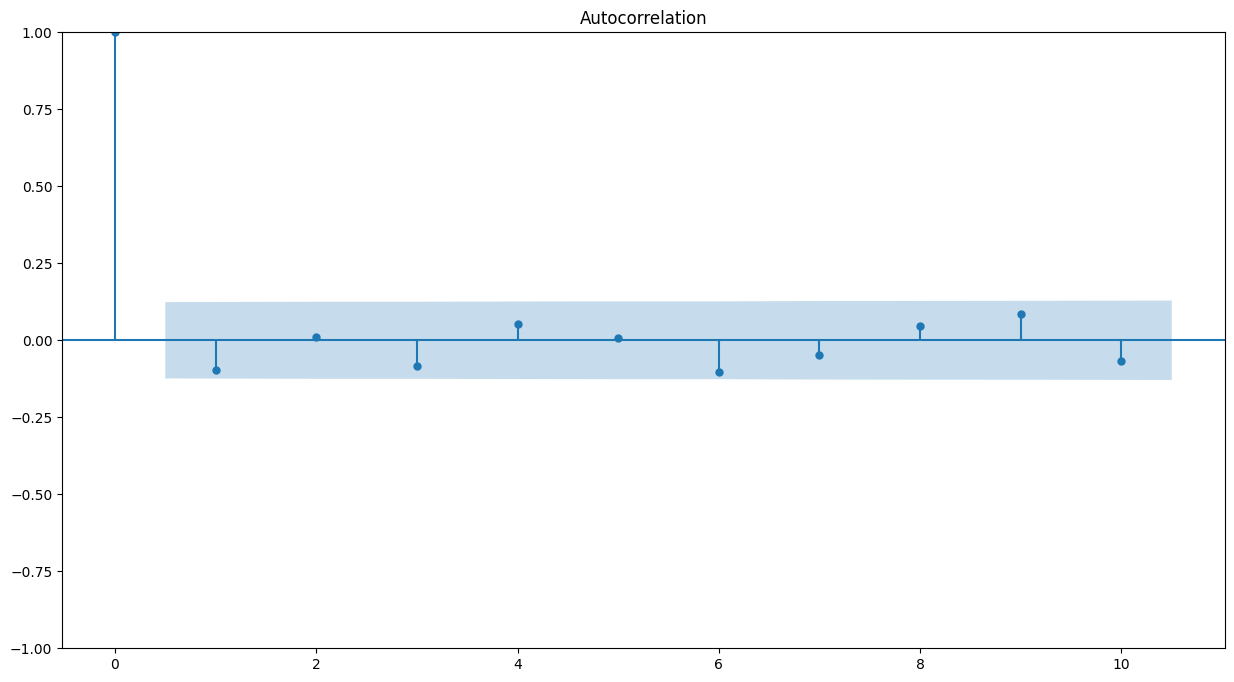

In [ ]:
# Aplicamos esta Autocorrelacion a la columna diferenciada.
plot_acf(df['Adj_Close_diff'], lags=10)
plt.show()

Al analizar el gráfico de Autocorrelación (ACF), notamos que solo uno de los rezagos cae fuera del rango de confianza, lo que indica una correlación significativa con los valores pasados de la serie de tiempo. Dado que este es el único rezago significativo, podemos estimar que el valor ideal de "q" en el modelo ARIMA es 0 o 1.
Algo que AUTOARIMA ya nos había indicado como un 0.

Para encontrar el valor adecuado de "p" en el modelo ARIMA, utilizamos la función de Autocorrelación Parcial (PACF).

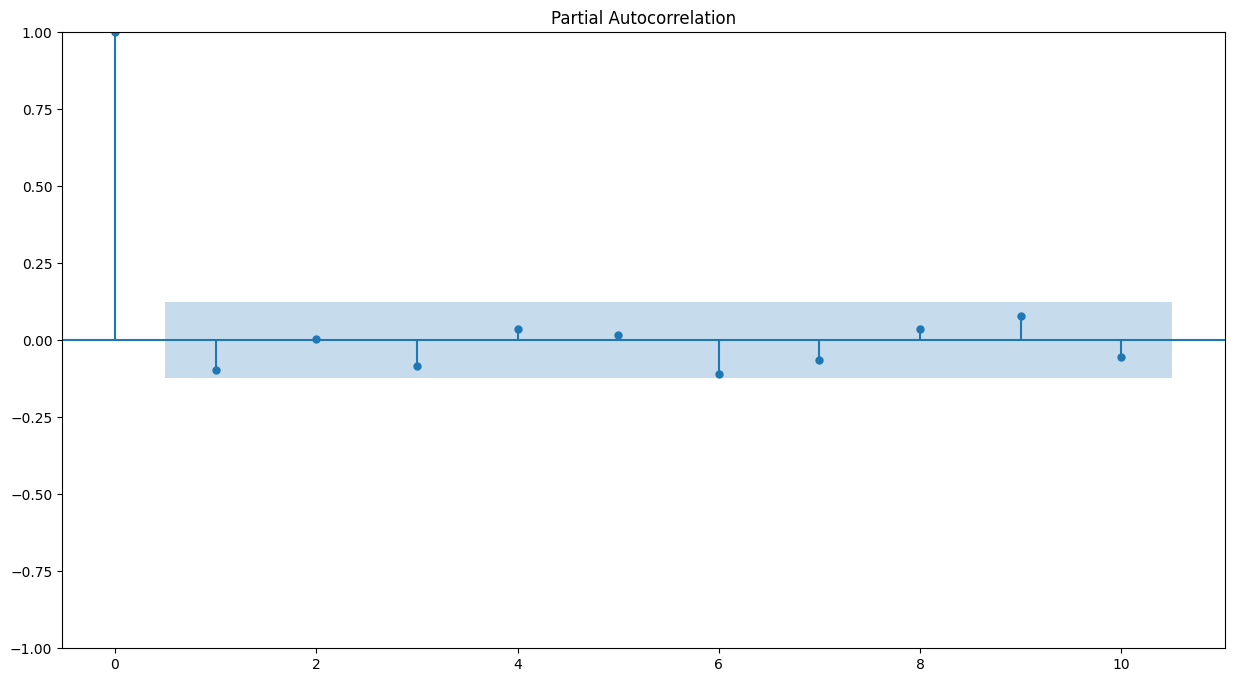

In [ ]:
# autocorrelación parcial (PACF) de la serie temporal sobre la columna diferenciada.
plot_pacf(df['Adj_Close_diff'], lags=10)
plt.show()

Dado que solo hay un rezago significativo en el gráfico de Autocorrelación Parcial (PACF), podemos concluir que el valor de "p" en el modelo ARIMA está en el rango de 0 o 1.

In [ ]:
#Declaramos variables para d, p y q con valor de 1
d= 1
p = 1
q= 1

In [ ]:
# Creamos y ajustamos el modelo ARIMA con los valores que hemos decidido.
model111 = ARIMA(df['Adj_Close_diff'], order=(p, d, q))
model_fit = model111.fit()

# Realizamos el entrenamiento.
predictions = model_fit.predict(start=len(df), end=len(df) + 365)

# PRUEBAS DE ERROR SOBRE ARIMA (1, 1, 1)

In [ ]:
#Hemos creado una función que nos ayudará a evaluar la eficacia de los modelos según vamos cambiando sus parámetros en p, q, y d.
def diagnostico_ARIMA(order):
    #Modelado de ARIMA
    model = ARIMA(df['Adj_Close_diff'], order=order)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(df), end=len(df) + 365)

    #Predicciones
    y_true = df['Adj_Close_diff'].values[:239]
    y_pred = predictions.values[:239]

    #Evaluación.
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mape = np.where(np.isfinite(mape), mape, 0)

    # Imprimir los resultados
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared (R2):", r2)
    print("Mean Absolute Percentage Error (MAPE):", mape)

    rcParams['figure.figsize'] = 12, 8

    # Graficar los diagnósticos
    model_fit.plot_diagnostics()
    plt.show()

Mean Absolute Error (MAE): 0.7786006671074257
Mean Squared Error (MSE): 0.9877351517363252
Root Mean Squared Error (RMSE): 0.993848656353836
R-squared (R2): 0.0007650411751344288
Mean Absolute Percentage Error (MAPE): 0.0


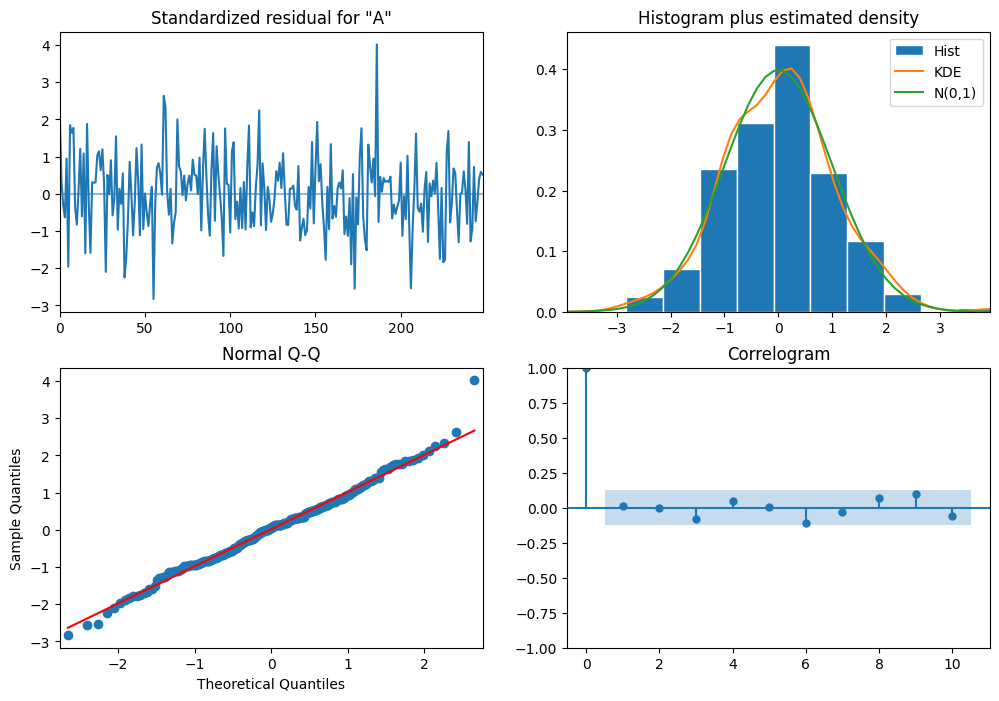

In [ ]:
# Este es el modelo que nosotros hemos considerado ideal.
diagnostico_ARIMA(order=(1, 1, 1))

Mean Absolute Error (MAE): En este caso, un valor de MAE de aproximadamente 0.78 un MAE más bajo sería mejor, y en general, un valor de MAE cercano a cero indica una buena precisión del modelo.

Mean Squared Error (MSE): El MSE es una medida del promedio de los errores al cuadrado entre las predicciones y los valores reales. Un valor de MSE de aproximadamente 0.99 indica que, en promedio, el error al cuadrado es alrededor de 0.99 unidades.  Debería de estar más cercano a 0.

Root Mean Squared Error (RMSE): El RMSE es simplemente la raíz cuadrada del MSE y proporciona una medida del error típico de las predicciones en la misma escala que los datos originales. En este caso es 0.99.

R-squared (R2): En este caso, un valor de R2 muy cercano a cero (0.0008) sugiere que el modelo tiene un ajuste pobre y no está explicando bien la variabilidad en los datos.
Mean Absolute Percentage Error (MAPE):Un valor de MAPE de 0.0 indica que el modelo no tiene errores en las predicciones, lo cual es poco probable y sugiere una posible sobreestimación del modelo.

En general, los resultados de las métricas indican que este modelo ARIMA no es muy preciso y no se ajusta bien a los datos.

Visto que no deberíamos usar este modelos ARIMA (1,1,1) vamos realizar una busqueda con el método AIC.

In [ ]:
# Bucle for para generar todas las combinaciones posibles dentro de los rangos que hemos visto pueden funcionar.
parametros = [(p, d, q) for p in range(2) for d in range(2) for q in range(2)]
print("Estos son todas las combinaciones que pueden ser validas " + str(parametros))

Estos son todas las combinaciones que pueden ser validas [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [ ]:
lista_aic = []

# Iteramos a traves de los parametros.
for p, d, q in parametros:
    #Aquí se crea el modelo.
    model = ARIMA(df['Adj_Close_diff'], order=(p, d, q))
    model_fit = model.fit()

    # Calculamos el aic y agregamos el valor a la lista.
    aic = model_fit.aic
    lista_aic.append(aic)

# Encontrar el modelo con el AIC más bajo
mejor_modelo = lista_aic.index(min(lista_aic))

In [ ]:
print("El mejor modelo para ARIMA es ARIMA"  + str(parametros[int( mejor_modelo)]) + " según el método AIC.")

El mejor modelo para ARIMA es ARIMA(1, 0, 0) según el método AIC.


Vamos a realizar las pruebas con estos nuevos parametros arrojados por el criterio AIC

Mean Absolute Error (MAE): 0.7785910701614308
Mean Squared Error (MSE): 0.9877036517992421
Root Mean Squared Error (RMSE): 0.9938328087758233
R-squared (R2): 0.0007969078534427743
Mean Absolute Percentage Error (MAPE): 0.0


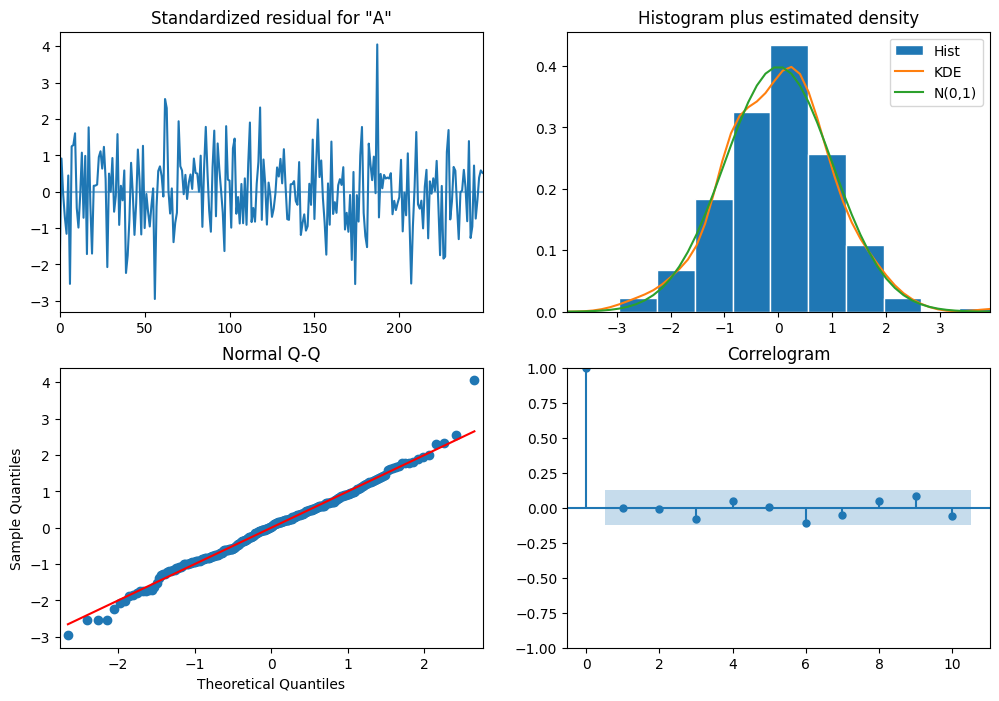

In [ ]:
diagnostico_ARIMA(order=(1, 0, 0))

Las métricas son muy parecidas al anterior y nos indican que tampoco es un modelo adecuado.

Mean Absolute Error (MAE): 0.8569885983263595
Mean Squared Error (MSE): 1.1975799976964299
Root Mean Squared Error (RMSE): 1.0943399826819953
R-squared (R2): -0.21152294477327938
Mean Absolute Percentage Error (MAPE): 0.0


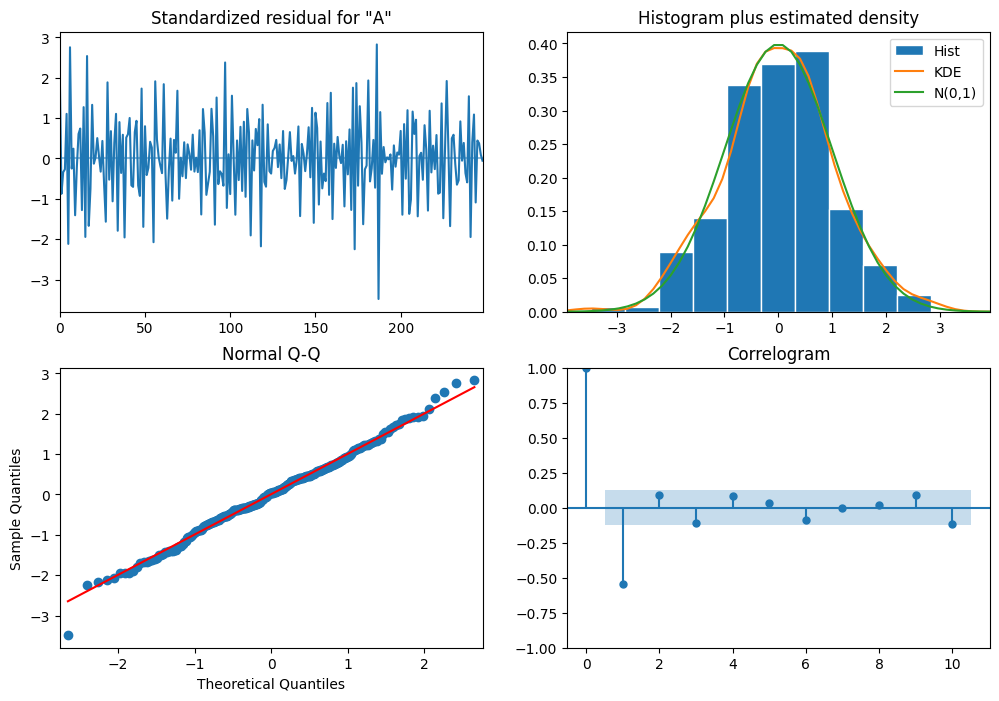

In [ ]:
#Probamos con el modelo de AUTOARIMA
diagnostico_ARIMA(order=(0, 1, 0))

Comparando estos resultados con los anteriores, podemos ver que el modelo de  AUTOARIMA tiene valores más altos para MAE, MSE y RMSE, lo que indica que las predicciones están más alejadas de los valores reales en promedio. Además, el R-cuadrado es negativo, lo que sugiere que el modelo no está explicando bien la variabilidad de los datos y puede estar ajustándose peor que un modelo lineal simple.

En cuanto al MAPE, el valor de 0.0 nuevamente parece inusual y puede haber algún error en el cálculo. El MAPE mide el porcentaje promedio de error entre las predicciones y los valores reales, y obtener un valor de 0.0 implicaría predicciones perfectas, lo cual es poco común en la práctica.

Basándonos en los resultados de las métricas de error y el valor negativo del coeficiente de determinación (R-cuadrado), podemos concluir que el modelo ARIMA utilizado en este caso no es adecuado para describir y predecir la variabilidad de los datos. Los errores obtenidos, como el MAE, MSE y RMSE, indican que las predicciones difieren en promedio alrededor de 56-57 unidades del valor real de la variable objetivo. Además, el valor negativo del R-cuadrado indica que el modelo no puede explicar la variabilidad de los datos de manera satisfactoria.

GRAFICAMOS EL MODELO ELEGIDO

Hemos decidido continuar utilizando el Modelo ARIMA(1, 1, 1) , ya que es el que se ha  investigado más exhaustivamente hasta el momento.

In [ ]:
model = ARIMA(df['Adj_Close_diff'], order=(1,1,1))
result_model = model.fit()
print(result_model.summary())

                               SARIMAX Results                                
Dep. Variable:         Adj_Close_diff   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -352.189
Date:                Sat, 22 Jul 2023   AIC                            710.378
Time:                        14:42:05   BIC                            720.930
Sample:                             0   HQIC                           714.625
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0951      0.063     -1.505      0.132      -0.219       0.029
ma.L1         -0.9998      0.940     -1.064      0.287      -2.842       0.842
sigma2         0.9687      0.905      1.071      0.2

In [ ]:
# Realizar predicciones para los próximos 365 días
forecast_steps = 365
forecast = result_model.get_forecast(steps=forecast_steps)

# Obtener las predicciones y los intervalos de confianza
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Calcular las predicciones absolutas sumando las diferencias a los valores originales
forecast_values = df['Adj_Close'].iloc[-1] + predicted_mean.cumsum()

# Crear un DataFrame con las predicciones y las fechas correspondientes
forecast_df = pd.DataFrame({'Predicted': forecast_values}, index=forecast.conf_int().index)

# Imprimir el DataFrame de predicciones
print(forecast_df)

     Predicted
250  58.138634
251  58.184969
252  58.226766
253  58.268995
254  58.311182
..         ...
610  73.331255
611  73.373446
612  73.415638
613  73.457829
614  73.500020

[365 rows x 1 columns]


In [ ]:
fig = px.line(forecast_df, x=forecast_df.index, y=['Predicted'], labels={'y': 'Predicted'}, line_shape='linear', title='ARIMA Forecast')

fig.show()

 <img src="perro.jpg" alt="Logo" width="100" height="100">Estas son las predicciones que me aparecen y no sé por qué no me predice. He revisado detenidamente el código y no puedo identificar el error... o tal vez este es el resultado esperado. Inicialmente, observaba una línea recta, pero ahora parece ser una línea ascendente, y en otras ocasiones, no obtenía ninguna predicción. Me siento frustrada por no identificar con certeza qué es lo que estoy haciendo mal.

Desconozco la causa exacta de los errores que está presentando el modelo ARIMA. A pesar de mis esfuerzos por buscar documentación y realizar consultas, aún no he encontrado una solución para solventar los problemas que están afectando las predicciones del modelo.

<p><b>Este comentario no estará incluido en el informe final representa una nota personal.</b></p> El informe final se centrará en los resultados obtenidos y las conclusiones relevantes basadas en el análisis realizado.

Si tuviera que comentar esta gráfica inferiria en que el pronostico de la empresa será favorable durante los proximos 365 días y que su tendencia es al alta. En todo caso sería un pronostico positivo.

## PROPHET

Prophet es una biblioteca de código abierto desarrollada por Facebook que se utiliza para el análisis y pronóstico de series de tiempo.

In [ ]:
#Comenzamos cargando datos.
df_ete = pd.read_csv('acciones_electrostock.csv', sep =',', index_col = 'Date')
df_ete.index = pd.to_datetime(df_ete.index)
df_ete = df_ete.rename(columns={'Adj Close': 'Adj_Close'})


In [ ]:
#Pasamos la frecuencia a diaria
df_ete = df_ete.asfreq('D')

In [ ]:
df_ete.fillna(method='ffill', inplace=True)
#Algunos días no tienem datos así que al pasarlo a frecuencia diaria quedan NaN
#Rellenamos los datos nulos con los datos del día anterior.

In [ ]:
df_ete = df_ete.reset_index()
# Seleccionar solo las columnas necesarias
df_ete = df_ete[['Date', 'Adj_Close']]

In [ ]:
df_ete = df_ete.rename(columns={'Date': 'ds', 'Adj_Close': 'y'})
# Renombra las columnas a 'ds' e 'y' respectivamente, Prophet solo necesita este Dataframe.

In [ ]:
# Hemos buscado los días festivos de España para añadirlos porque posiblemente influyan en las predicciones.
holidays_spain = pd.DataFrame({
    'holiday': 'Spain Holidays',
    'ds': pd.to_datetime(['2023-01-01', '2023-01-06', '2023-05-01', '2023-08-15', '2023-10-12',
                         '2023-11-01', '2023-12-06', '2023-12-08', '2023-12-25']),
    'lower_window': 0,
    'upper_window': 0,
})

In [ ]:
#Entrenamos Prophet.
model = Prophet(weekly_seasonality=True, holidays=holidays_spain)
model.fit(df_ete)

14:42:07 - cmdstanpy - INFO - Chain [1] start processing
14:42:08 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
#Dataframe del futuro
future = model.make_future_dataframe(periods=365)
forecastprophet = model.predict(future)

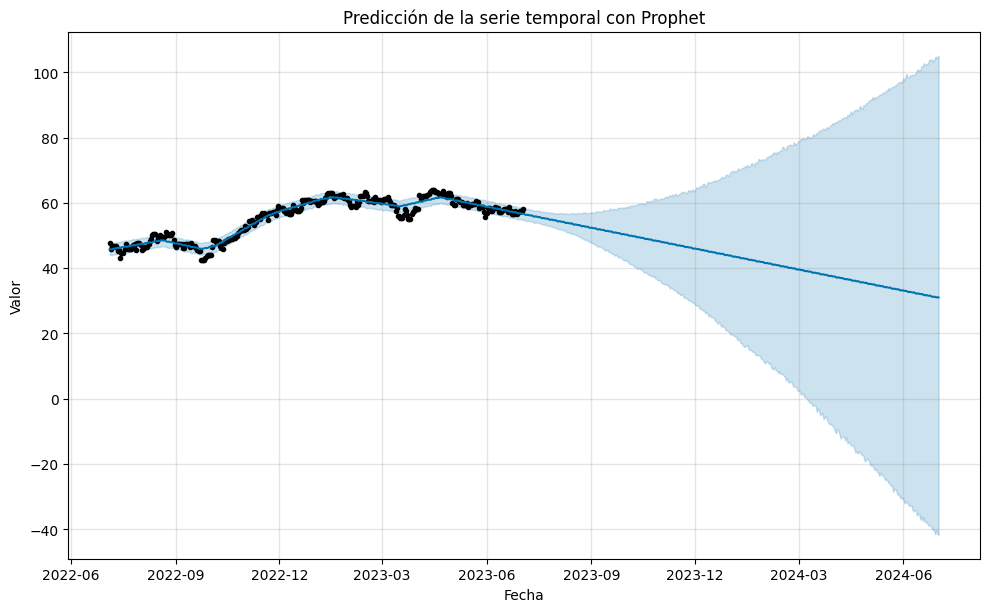

In [ ]:
# Visualización de las predicciones
fig = model.plot(forecastprophet)
plt.title('Predicción de la serie temporal con Prophet')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.show()


VALIDACIÓN PROPHET.

In [ ]:
# Dividimos los datos en conjuntos de entrenamiento y prueba (ejemplo: 80% entrenamiento, 20% prueba)
train_size = int(len(df_ete) * 0.8)
train_data = df_ete[:train_size]
test_data = df_ete[train_size:]

# Entrenamos el modelo.
model = Prophet(weekly_seasonality=True, holidays=holidays_spain)
model.fit(train_data)

# El futuro ya está aquí
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

forecast_test = forecast[-len(test_data):]

# Calculamos los errores de validación
mae = mean_absolute_error(test_data['y'], forecast_test['yhat'])
mse = mean_squared_error(test_data['y'], forecast_test['yhat'])
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

14:42:09 - cmdstanpy - INFO - Chain [1] start processing
14:42:09 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 1.3981
Mean Squared Error (MSE): 3.6440
Root Mean Squared Error (RMSE): 1.9089


Comparando estos valores con los de ARIMA (1, 1, 1) podemos observar que el modelo anterior tiene mejores resultados en términos de MAE, MSE y RMSE, ya que sus valores son más bajos que los del modelo Prophet. Esto indica que el modelo anterior tiene un mejor desempeño en la predicción y es más preciso en comparación con el modelo Prophet.

El R-squared (R2) del modelo anterior es muy bajo, lo que sugiere que el modelo no está explicando bien la variabilidad de los datos. Además, el MAPE del modelo anterior es de 0.0, lo cual puede indicar un posible sobreajuste del modelo.

● BOOSTING CATBOOST

In [ ]:
X = df.drop(columns=['Adj_Close', 'Date'])
y = df['Adj_Close']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crearmos el modelo CatBoostRegressor
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, loss_function='RMSE', random_seed=42)

# Entrenamos el modelo
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)

# Realizamos predicciones en el conjunto de prueba
y_pred_catboost = catboost_model.predict(X_test)


0:	learn: 5.4935293	test: 5.8328532	best: 5.8328532 (0)	total: 29.1ms	remaining: 29.1s
100:	learn: 0.5589985	test: 0.7874021	best: 0.7856606 (90)	total: 358ms	remaining: 3.19s
200:	learn: 0.3514553	test: 0.8023562	best: 0.7824862 (118)	total: 676ms	remaining: 2.69s
300:	learn: 0.2370388	test: 0.8138226	best: 0.7824862 (118)	total: 1.07s	remaining: 2.48s
400:	learn: 0.1633383	test: 0.8258446	best: 0.7824862 (118)	total: 1.35s	remaining: 2.02s
500:	learn: 0.1146243	test: 0.8319103	best: 0.7824862 (118)	total: 1.63s	remaining: 1.62s
600:	learn: 0.0807423	test: 0.8367616	best: 0.7824862 (118)	total: 1.93s	remaining: 1.28s
700:	learn: 0.0569761	test: 0.8391067	best: 0.7824862 (118)	total: 2.22s	remaining: 947ms
800:	learn: 0.0418204	test: 0.8409351	best: 0.7824862 (118)	total: 2.5s	remaining: 623ms
900:	learn: 0.0296667	test: 0.8426409	best: 0.7824862 (118)	total: 2.8s	remaining: 308ms
999:	learn: 0.0225286	test: 0.8429585	best: 0.7824862 (118)	total: 3.12s	remaining: 0us

bestTest = 0.7824

In [ ]:
# Creamos un DataFrame con las fechas del conjunto de prueba
forecast_dates = X_test.index

# Creamos un DataFrame con las predicciones y las fechas correspondientes
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Predicted': y_pred_catboost})
forecast_df.set_index('Date', inplace=True)
forecast_df.sort_index(inplace=True)

In [ ]:
#Ordenamos las fechas que en un primer momento aparecian totalmente descolocadas.
X_test['Date'] = forecast_df.index
X_test.sort_values(by='Date', inplace=True)

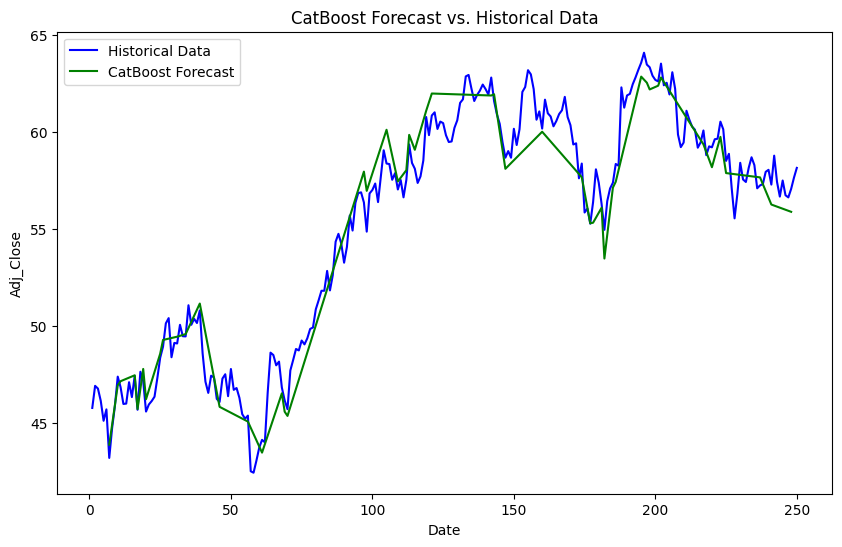

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['Adj_Close'], label='Historical Data', color='blue')
plt.plot(forecast_df['Predicted'], label='CatBoost Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Adj_Close')
plt.title('CatBoost Forecast vs. Historical Data')
plt.legend()
plt.show()

Aparentemente, el pronóstico parece positivo, pero tengo la intuición de que algo no está del todo correcto y no logro identificarlo claramente.

¿Existe la posibilidad de que el modelo esté sufriendo de sobreajuste.?

3. Análisis de Resultados y Selección de Modelo.



<h2>ARIMA(1,1,1):</h2>
<ul>
  <li>Mean Absolute Error (MAE): 0.7786</li>
  <li>Mean Squared Error (MSE): 0.9877</li>
  <li>Root Mean Squared Error (RMSE): 0.9938</li>
  <li>R-squared (R2): 0.0008</li>
  <li>Mean Absolute Percentage Error (MAPE): 0.0</li>
</ul>

<h2>ARIMA(1,0,0) con AIC:</h2>
<ul>
  <li>Mean Absolute Error (MAE): 0.7786</li>
  <li>Mean Squared Error (MSE): 0.9877</li>
  <li>Root Mean Squared Error (RMSE): 0.9938</li>
  <li>R-squared (R2): 0.0008</li>
  <li>Mean Absolute Percentage Error (MAPE): 0.0</li>
</ul>

<h2>AUTOARIMA:</h2>
<ul>
  <li>Mean Absolute Error (MAE): 0.8569</li>
  <li>Mean Squared Error (MSE): 1.1976</li>
  <li>Root Mean Squared Error (RMSE): 1.0943</li>
  <li>R-squared (R2): -0.2115</li>
  <li>Mean Absolute Percentage Error (MAPE): 0.0</li>
</ul>

<h2>Prophet:</h2>
<ul>
  <li>Mean Absolute Error (MAE): 1.3981</li>
  <li>Mean Squared Error (MSE): 3.6440</li>
  <li>Root Mean Squared Error (RMSE): 1.9089</li>
</ul>

<h2>CatBoost:</h2>
<ul>
  <li>MAE: 0.6399</li>
  <li>MSE: 0.6123</li>
  <li>RMSE: 0.7825</li>
  <li>R2: 0.9845</li>
</ul>


In [ ]:
# Datos de los modelos
modelos = ['ARIMA(1,1,1)', 'ARIMA(1,0,0) con AIC', 'AUTOARIMA', 'PROPHET', 'CATBOOST']
rmse = [0.9938, 0.9938, 1.0943, 1.9089, 0.7825]
mse = [0.9877, 0.9877, 1.1976, 3.6440, 0.6123]
mae = [0.7786, 0.7786, 0.8569, 1.3981, 0.6399]

In [ ]:
# Crear un DataFrame para los datos
df = pd.DataFrame({
    'Modelo': modelos * 3,
    'Métrica': ['RMSE', 'MSE', 'MAE'] * len(modelos),
    'Valor': rmse + mse + mae
})

In [ ]:
#Graficamos
fig = px.bar(df, x='Valor', y='Modelo', color='Métrica', orientation='h',
             labels={'Valor': 'Valor', 'Modelo': 'Modelo'},
             title='Comparación de RMSE, MSE y MAE entre modelos.',
             barmode='group', height=500)

# MostraMOS los valores en las barras
for i in fig.data:
    for j in i.x:
        fig.add_annotation(
            x=j,
            y=i.y[i.x == j][0],
            text=f"{j:.4f}",
            showarrow=False,
            font=dict(size=10)
        )

# Mostrar el gráfico
fig.show()

Los modelos ARIMA(1,1,1) y ARIMA(1,0,0) con AIC tienen resultados muy similares, lo que sugiere que ambos ajustan bien los datos.

El modelo Prophet muestra un RMSE más alto en comparación con los modelos ARIMA y CatBoost, lo que podría indicar que su rendimiento es menos preciso en este caso.
También muestra un MAE muy por encima del resto y es probable que las predicciones del modelo Prophet están más lejos de los valores reales en promedio

El modelo CatBoost presenta el MAE, MSE y RMSE más bajos, lo que indica que tiene un mejor rendimiento en la predicción. Además, su valor de R2 es cercano a 1, lo que sugiere que explica una gran parte de la variabilidad de los datos. Esto implica que CatBoost se ajusta mejor a los datos reales que los demás modelos evaluados.
lo que resulta en un rendimiento mejor.

Mi eleccion según los datos presentados serían con el modelo CatBoostRegressor, pero como comenté anteriormente creo que tiene overfitting y habría que cambiar hiperparametros.